# MyNN Implementation for Tendril Classification

In [17]:
import mygrad as mg

from datasets import ToyData
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

We've used a two-layer neural network to solve a classification problem on a toy data set: a spiral formation of 2D data points. In this notebook, we will rewrite our solution to take advantage of MyNN, our main neural network library. This will serve as a gentle introduction to the library, which will prove to be very useful in moving forward with neural networks. In fact, MyNN is similar in spirit to PyTorch, so the insight you gain using MyNN will be helpful in moving on to full-scale deep learning libraries.

As before, let's construct and visualize our dataset

In [18]:
# Constructing the spiral dataset and its labels.
###################################STUDENT CODE#############################################
num_tendrils = 3 #change the num of tendrils and rerun  the cells
data_dim = 2
data = ToyData(num_classes=num_tendrils, dimensionality=data_dim)

xtrain, ytrain, xtest, ytest = data.load_data()

<IPython.core.display.Javascript object>


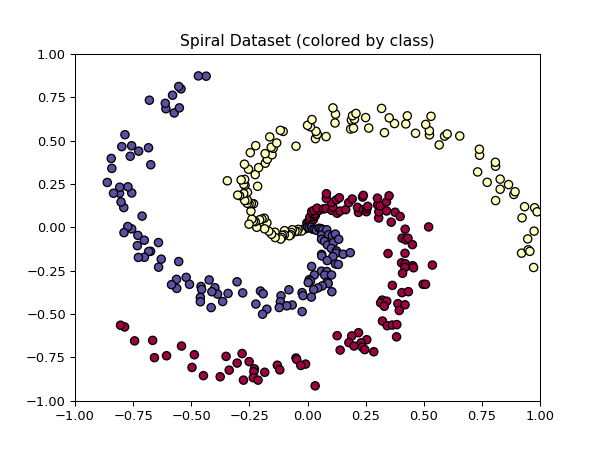

In [19]:
fig, ax = data.plot_spiraldata()

We'll reuse our accuracy function from the previous notebook that checked how accurate our model's predictions were.

In [20]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

## Creating our model

Before, we had to construct the parameters of our neural network manually; recall that we created a `w`, `b`, and `v` ourselves with randomly initialized numpy arrays. Additionally, we had to manually perform gradient descent in order to update our parameters. One of the main advantages of using a neural network library such as MyNN is that this sort of low-level implementation is already taken care of. Essentially, neural network libraries will package up the general form of various functionality we may want to use such as gradient descent so that we can focus on algorithmic developments rather than reimplementing gradient descent every time we want to train a network.

We were using fully-connected (dense) layers to solve our classification problem. These are packaged up conveniently inside MyNN in the `layers` module. Let's import the dense layer now:

In [21]:
from mynn.layers.dense import dense

When we create a dense layer, we simply hand it the input dimensionality and the number of units that it should have. We can then call that layer like a function to pass data through it. As an example:

``` python
>>> test = dense(1, 3)
>>> test(np.random.rand(4, 1))
Tensor([[0.05937882, 0.03772544, 0.3315828 ],
        [0.03664506, 0.02328189, 0.2046331 ],
        [0.12491025, 0.07935985, 0.69752296],
        [0.01663779, 0.01057057, 0.09290864]])
```

This will handle the whole matrix multiplication and bias addition for us, which results in much less bookkeeping (and less potential for mistakes) on our end.  By printing out ```test.weight``` or ```test.bias``` you can see that they are all contained in this variable and we no longer need to create our w and b!

There are other types of layers (such as `conv`) packaged inside MyNN as well. You may have already thought to reuse some of the code that you wrote in the universal function approximator or in the Tendril classifier you wrote using plain MyGrad already; this is essentially all that MyNN is doing: packaging up useful chunks of code so that we can more easily, more quickly, and with fewer mistakes implement neural networks.

We'll also need to use our ReLU activation function. It and other activations are stored in `mynn.activations`. Let's import that now:

In [22]:
from mynn.activations.relu import relu

The final piece we need to create our model is a weight initializer. In MyGrad, we used a Gaussian to initialize our weights, and initialized our bias to 0. By default, MyNN will initialize a bias to zero, but we will need to pass in an initializer for the weight matrix; by default, MyNN will use a unifrom distribution. The normal (Gaussian) distribution and all other initializers are in `mynn.initializers`.

In [23]:
from mynn.initializers.normal import normal

In fact, you've already used MyNN to perform your weight initialization! That functionality was packaged inside `mynn.initializers`. There are several other initialization schemes defined in that module; feel free to poke around and explore.


Let's recreate the model that we developed before using MyNN this time!  This model class will maintain all of our layers and define how to propagate input through the network. By creating a model class, we can both organize the layers for our neural network as well as create a simple way for running a forward pass on our data through every layer. Creating a model object and passing in our data will give us the output of our model - it's that simple.

In ```__init__(self)``` we simply define our layers - in this case we have two dense layers as denoted by dense1 and dense2.  TO understand what happens in the dense layer try reading the documentation for ```dense()```

In [24]:

class Model:
    
    def __init__(self, n, num_tendrils):
        ########################################STUDENT CODE##################################
        #To add more layers, call the self.name of layer = dense(size of previous layers, new size, weight_initializer=normal)
        self.dense1 = dense(data_dim, n, weight_initializer=normal)
        self.dense2 = dense(n, num_tendrils, weight_initializer=normal)
        
    def __call__(self, x):
        ''' Forward data through the network.
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(N, D)
            The data to forward through the network.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, 1)
            The model outputs.
        '''
        
        #We pass our data through a dense layer, use the activation function relu and then pass it through our second dense layer
        ########################################STUDENT CODE##################################
        #Add x = self.name of layer(relu(x)) for each extra layer
        x = self.dense1(x)
        x = self.dense2(relu(x))
        return x
        
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        ########################################STUDENT CODE##################################
        #Add + self.name of layer.paramters for each extra layer to the return statement
        return self.dense1.parameters + self.dense2.parameters

In [25]:
########################################STUDENT CODE##################################
model = Model(100, num_tendrils) # change 100 to change the size of the layers

As before, we'll use the softmax cross-entropy loss. This and other loss functions are stored inside `mynn.losses`

In [26]:
from mynn.losses.cross_entropy import softmax_cross_entropy

Lastly, in MyGrad we had to write the gradient descent function ourselves. This is also taken care of in MyNN. As you know, gradient descent is an optimization method; thus, it is located inside `mynn.optimizers`.

In [27]:
from mynn.optimizers.sgd import SGD

When we construct an optimizer, we must pass it the parameters of our model and any additional hyperparameters (such as learning rate). After we have backpropagated our loss through our network by calling `loss.backward()`, we can call `step()` on the optimizer to perform a single step of the optimization procedure. In our case, the `step()` function will loop over all the parameters of our model and update them according to the gradient descent algorithm.

In [28]:
########################################STUDENT CODE##################################
optim = SGD(model.parameters, learning_rate=0.1) #change 0.1 to change the learning rate

As before, we'll create a plot to see our loss and accuracy.

<IPython.core.display.Javascript object>


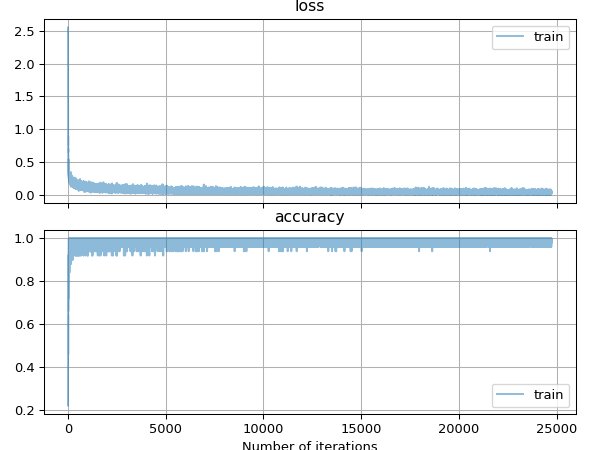

In [29]:
import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)
########################################STUDENT CODE##################################
batch_size = 50 # change 50 to change the batch size

We can use the same exact training loop structure as before. However, MyNN will take care of most of this for us. We'l ljust need to:

- randomize our indices
- get a batch of training data
- call `model(batch)` on the data to get outputs
- get the truth
- compute the loss by calling `softmax_cross_entropy(predictions, truth)`
- backpropagate the loss
- call `optim.step()` to perform SGD
- null the gradients
- plot our training statistics

In [30]:
for epoch_cnt in range(5000):
    idxs = np.arange(len(xtrain))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(xtrain)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = xtrain[batch_indices]  # random batch of our training data

        prediction = model(batch) #our forward pass through every layer is done utilizing the model class written above
        truth = ytrain[batch_indices]
        
        loss = softmax_cross_entropy(prediction, truth)
        acc = accuracy(prediction, truth)
        loss.backward()
        
        optim.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)

As before, we can visualize our decision boundary.

<IPython.core.display.Javascript object>


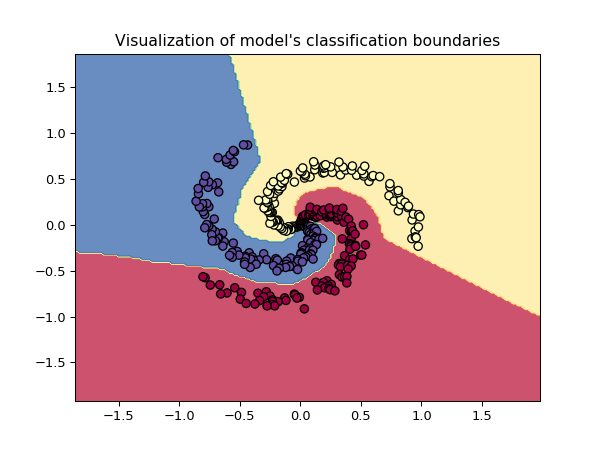

In [31]:
def dummy_function(x):
    from mygrad.nnet.activations import softmax
    return softmax(model(x)).data

fig, ax = data.visualize_model(dummy_function, entropy=False);